# README

# 実行環境の前提条件

* Notebook環境
  - [Jupyter Notebook for Literate Computing for Reproducible Infrastructure](https://github.com/NII-cloud-operation/Jupyter-LC_docker)
* VCP SDK
  - バージョン: 18.10.0
* クラウドプロバイダ
  - AWS
  - Microsoft Azure
    
<!---
  - VCPSDK APIドキュメント
    + /notebooks/notebook/DOC/ に配置されていることを想定しています
--->

# VCP SDK

## VCP SDKとは？

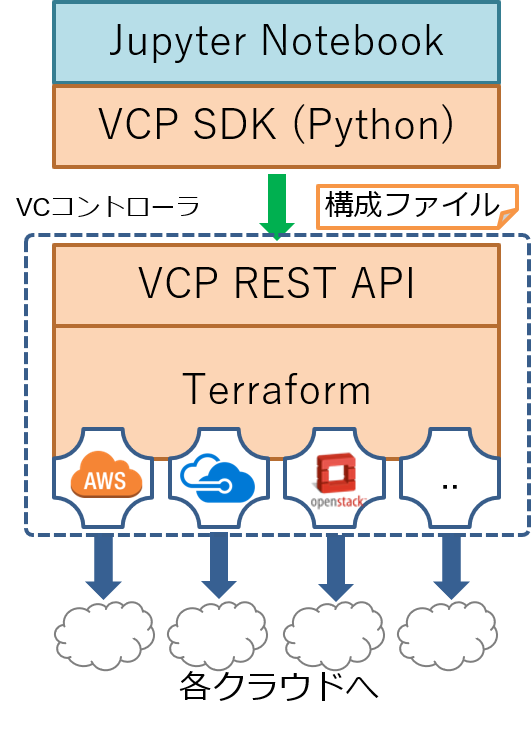

* VCPを操作するための Python3 ライブラリ
* VCコントローラの REST API に対するラッパーライブラリ(vcplib)を呼び出している
* クラウドごとの制御APIの差異を吸収
* 仮想マシン(Amazon EC2インスタンス, Microsoft Azure VM, ...)などの計算資源と、Amazon EBS, Microsoft Azure Managed Disksなどの記録媒体を作成、削除することができる

## 基本的な構成要素

VCP SDKが扱う構成要素を以下に記します。

* VC(Virtual Cloud)
  - 複数のクラウドにまたがって構築されたひとつの仮想システム環境
* UnitGroup
  - 複数のUnitをまとめて扱うためのものです
  - サーバ、クライアントなどの相互に関係をもつ異質なNode群をグループとしてまとめます
  - `compute` と `storage` の2つのタイプがあります
    + `compute` は仮想マシンなどの計算資源で構成されています
    + `storage` はブロックデバイスなどの記録媒体で構成されています
* Unit
  - 同質（同じ計算資源(cpu, memory, ...)、同じクラウド、同じ用途、...）であるNodeをまとめて扱うためのものです
  - Unitに属するNodeをスケールアウト、スケールインすることができます
* Node
  - UnitGroupを構成する個々のノード
  - UnitGroupのタイプが `compute`の場合
    - [Amazon EC2インスタンス](https://aws.amazon.com/jp/ec2/), [Microsoft Azure VM](https://azure.microsoft.com/ja-jp/services/virtual-machines/) など
    - VCP SDKではこのNodeをVCノードと呼びます
  - UnitGroupのタイプが `storage`の場合
    - [Amazon EBS](https://aws.amazon.com/jp/ebs/), [Microsoft Azure Managed Disks](https://azure.microsoft.com/ja-jp/services/storage/disks/) など
    - VCP SDKではこのNodeをVCディスクと呼びます

VC, UnitGroup, Unit の例を以下の図に示します。

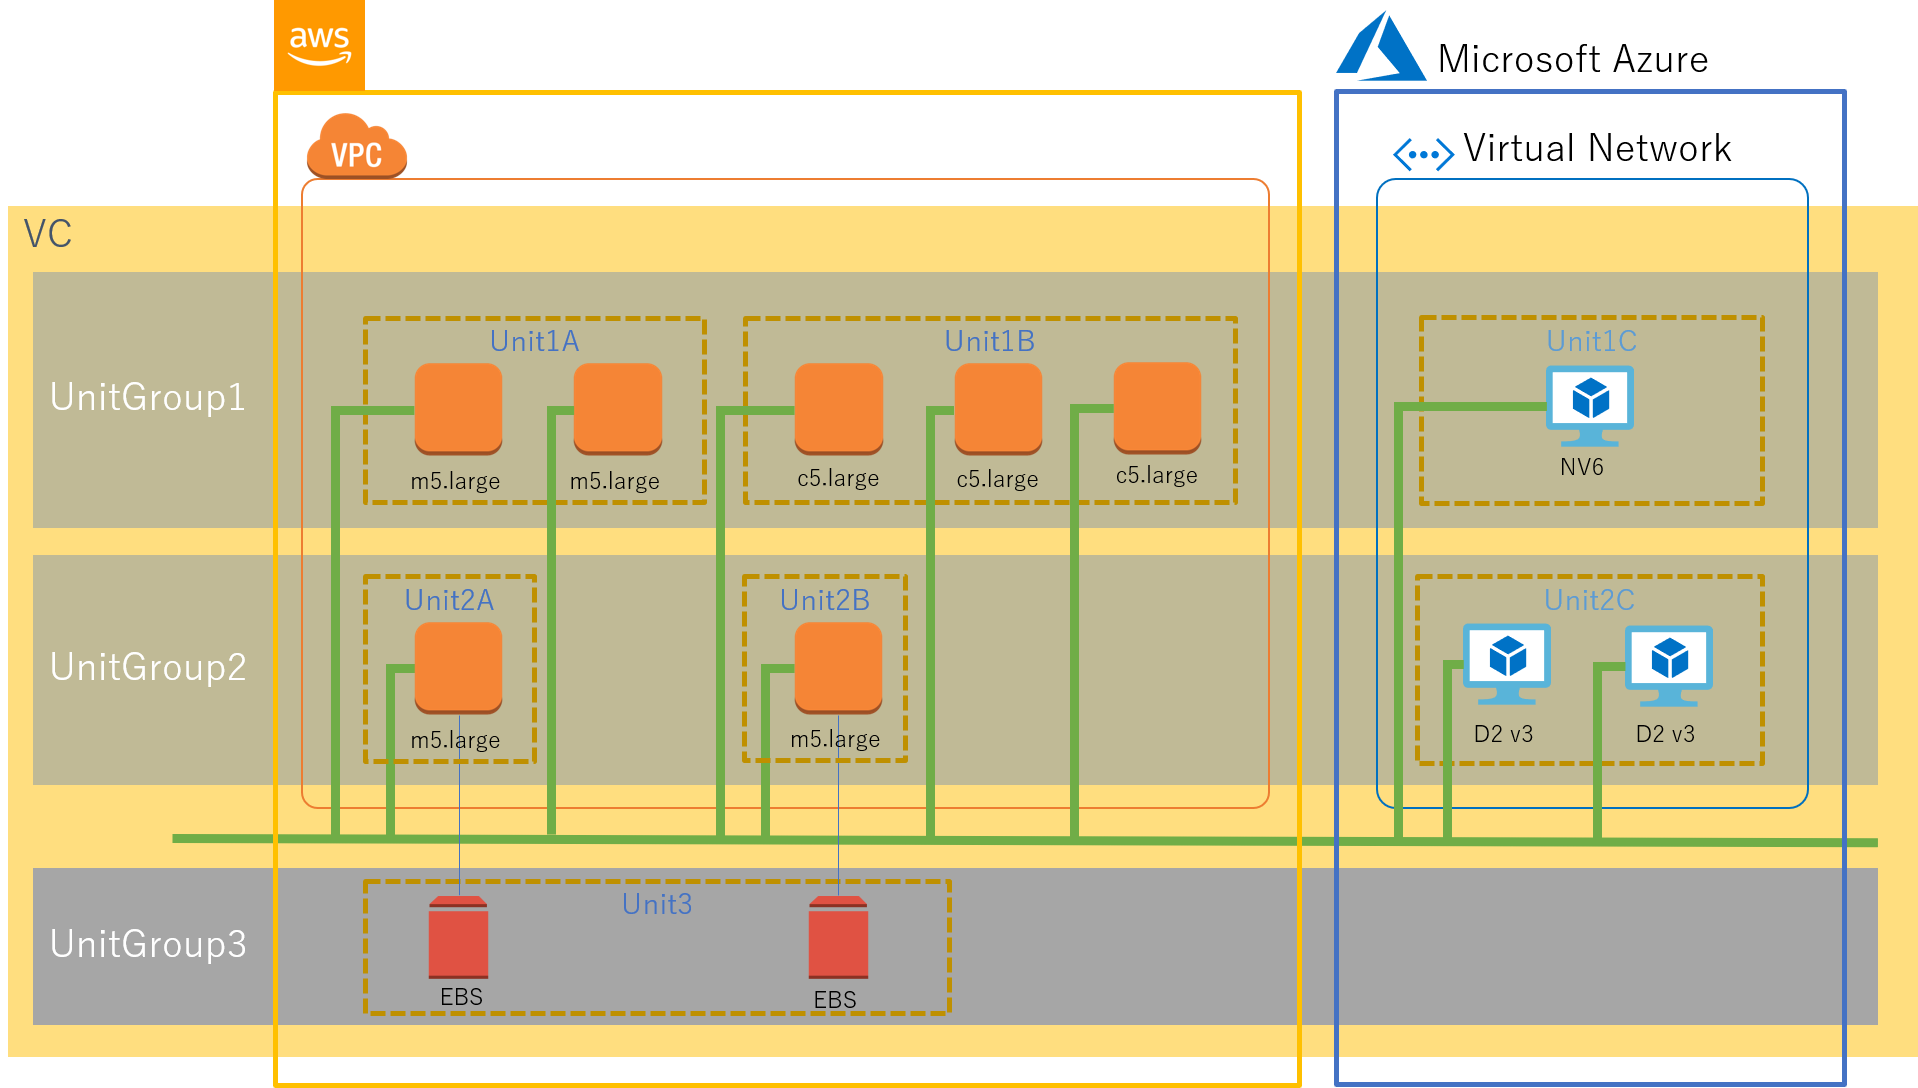

* UnitGroup1: ３つの Unit から構成されている `compute` タイプのUnitGroup
  - Unit1A
    * Amazon EC2 m5.large インスタンスで構成されている Unit
  - Unit1B
    * Amazon EC2 c5.large インスタンスで構成されている Unit
  - Unit1C
    * Microsoft Azure VM NV6 で構成されている Unit
* UnitGroup2: ３つの Unit から構成されている compute タイプのUnitGroup
  - Unit2A
    * Amazon EC2 m5.large で構成されている Unit
  - Unit2B
    * Amazon EC2 m5.large で構成されている Unit
  - Unit2C
    * Microsoft Azure VM D2 v3 で構成されている Unit
* UnitGroup3: １つの Unit から構成されている storage タイプのUnitGroup
  - Unit3
    * Amazon EBS から構成されている Unit

## VCノードについて

VCPの計算資源として利用できる環境はパブリッククラウドの仮想マシン(Amazon EC2, Microsoft Azure VM, ...)やベアメタル(BM)など多岐にわたっています。VCPではそのいずれに対しても同一の環境を提供できるようにするために[Docker コンテナ](https://www.docker.com/)を利用しています。クラウド上のVM/BMをVCノードとして組み入れる際にVCPが各VM/BMに共通環境となるコンテナを起動します。VCPではこのコンテナのことをBaseコンテナと呼んでいます。またBaseコンテナはVCノードのモニタリングなどのVCPの共通機能を提供するための役割も担っています。

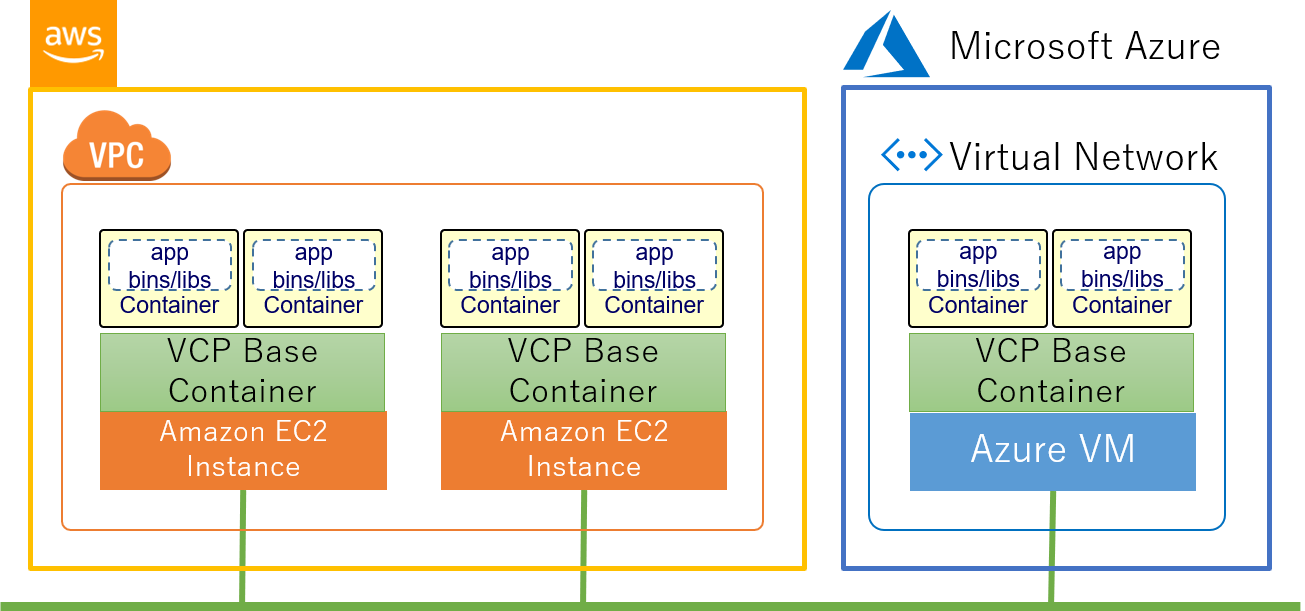

標準のBaseコンテナは以下のような特徴を有しています。

* [Alpine Linux コンテナ](https://hub.docker.com/_/alpine/)
* sshでログイン可能
* docker 実行環境(Docker in Docker)

標準のBaseコンテナは Alpine Linuxベースですが、他に Ubuntuベース、CentOSベースのものも用意しています。
また汎用的なBaseコンテナ以外にNFSサーバやGPU利用などの特定目的をもったBaseコンテナを用意しています。

# ハンズオン環境へのアクセス（参考）

ハンズオンのNotebook環境にはAWSのパブリックサブネットに配置したNATインスタンスのリバースプロキシ(Nginx)を経由してアクセスできるように設定されています。Notebook環境とVCP SDKによって起動されるVCノードはプライベートサブネットに配置されます。

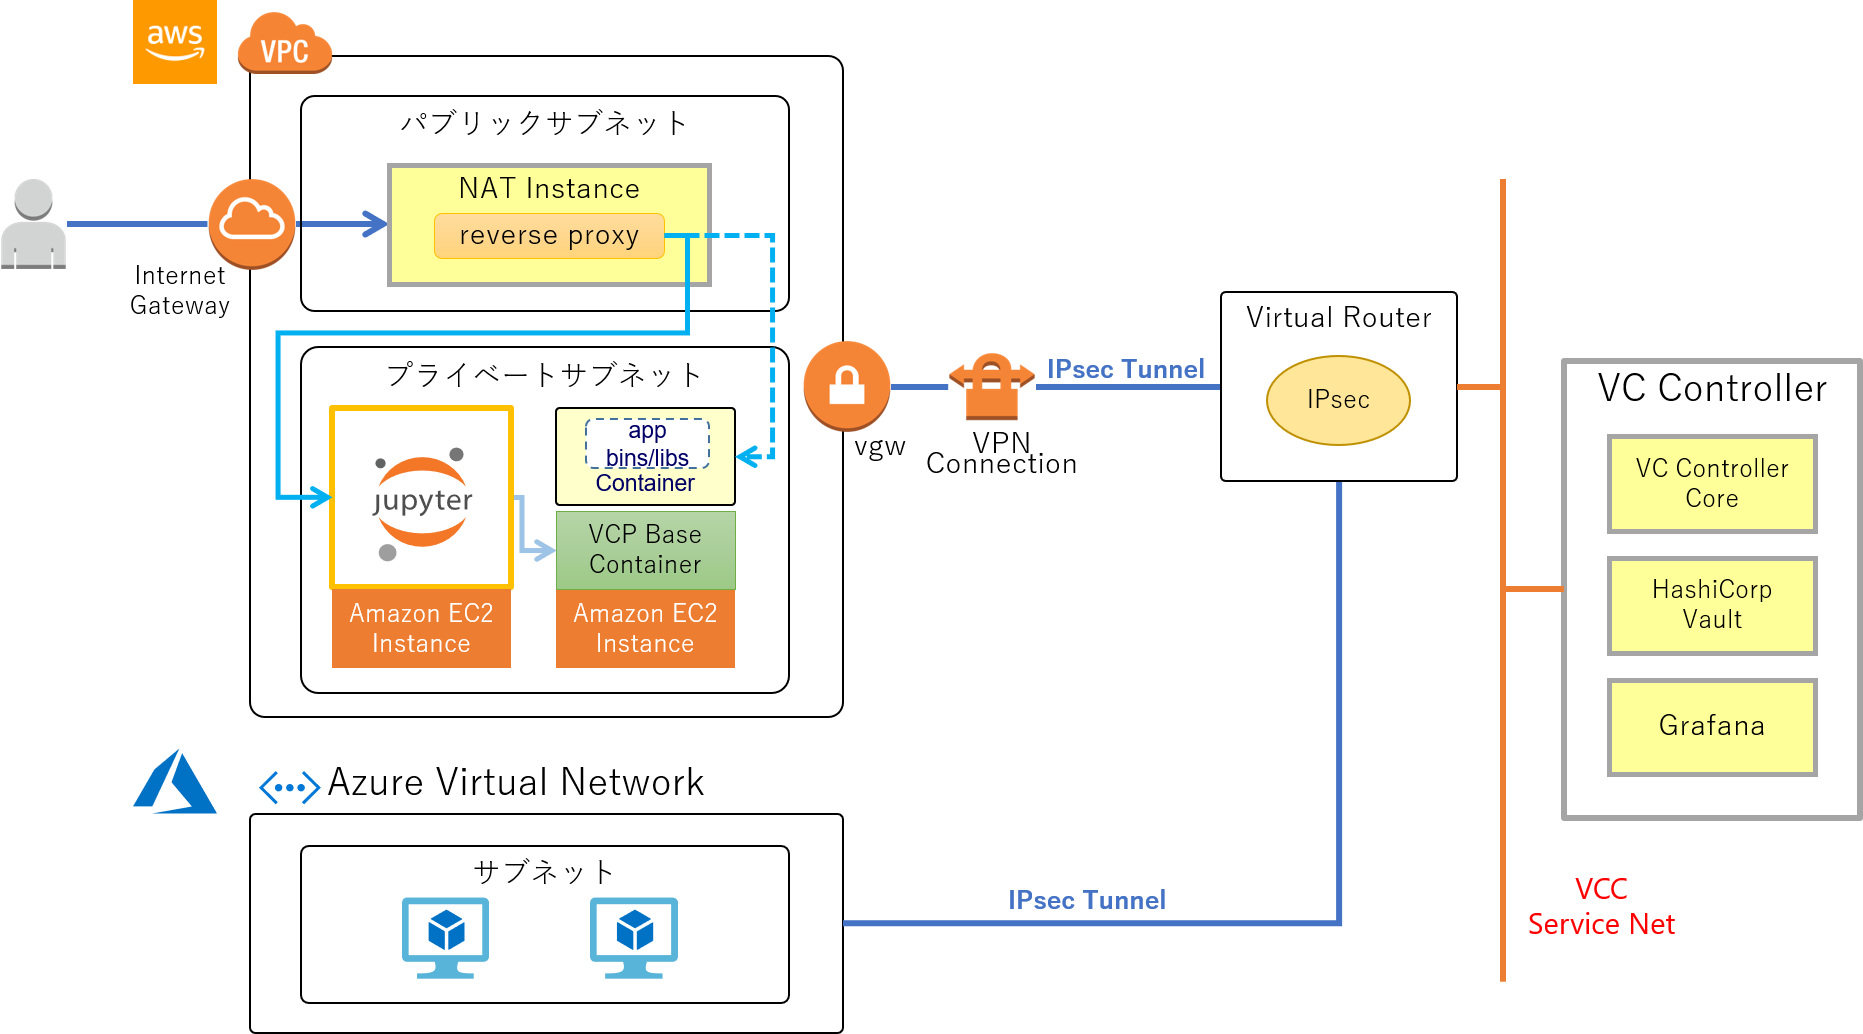

# 準備

この後に実行するNotebookで必要となるSSHの公開鍵認証のための鍵ファイルを作成します。
作成したSSHの鍵ファイルはこのNotebook環境からVCノードにログインする際に利用します。

次のセルを実行してください。

In [1]:
!mkdir -p ~/.ssh
!test -f ~/.ssh/id_rsa || ssh-keygen -t rsa -f ~/.ssh/id_rsa -N ""
!ls -la ~/.ssh

total 40
drwx------  2 bit_kun users 4096 Sep 21 18:03 .
drwxr-xr-x 25 bit_kun users 4096 Sep 21 18:23 ..
-rw-r--r--  1 bit_kun users  222 Sep 21 18:03 config
-rw-------  1 bit_kun users  411 Aug 20 14:23 id_ed25519
-rw-------  1 bit_kun users  464 Sep  6 15:17 id_ed25519_koiz
-rw-r--r--  1 bit_kun users  102 Sep  6 15:17 id_ed25519_koiz.pub
-rw-r--r--  1 bit_kun users  102 Aug 20 14:23 id_ed25519.pub
-rw-------  1 bit_kun users 1676 Jul 29 16:55 id_rsa
-rw-------  1 bit_kun users 3760 Sep  7 20:33 known_hosts
-rw-------  1 bit_kun users 2212 Aug 20 14:57 known_hosts.old


# Notebook一覧